https://dacon.io/competitions/official/235864/data

In [30]:
!pip install gdrive_dataset

In [31]:
!pip install konlpy

In [32]:
#한글 폰트 깨짐 방지
!sudo apt-get install -y fonts-nanum #코랩 한글 폰트 꺠짐 방지 폰트 설치
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Kkma
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [34]:
from gdrivedataset import loader
file_id = '1IbyL1762M0Lgoq7_qm2RaXfl3ney0e9i'
loader.load_from_google_drive(file_id)

========== files ============

data/dataset



In [35]:
DATA_DIR = '/content/data/dataset/'
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None


In [36]:
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [37]:
train.isna().sum() #결측치 확인

id          0
document    0
label       0
dtype: int64

In [38]:
test.head()

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy
3,4,멋있는 영화입니다. 잊을 수 없는!
4,5,너무 감동적이네요 펑펑 울었습니다


In [39]:
train.drop(['id'],axis=1, inplace=True)

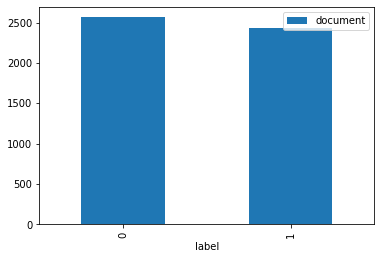

In [40]:
#데이터의 label분포 확인
train.groupby('label').count().plot.bar()

In [41]:
#정규표현식을 사용하여 글자만 추출
document = train['document'].str.replace('[^a-z|A-Z|ㄱ-ㅎ|가-힣|]','', regex=True)

In [42]:
from tqdm import tqdm
#특수문자,불용어제거, 토큰화를 실행한다.
stop_words=['ㅋㅋ']

okt = Okt() #토크나이징을 실시한다.
kkm = Kkma()
token_list = []
for sentence in tqdm(document):
  token = okt.morphs(sentence,stem=True)
  if len(token) < 2 : #못자르는 경우 kkma로 별도로 한번더 잘라줬습니다.
    token = kkm.morphs(sentence)
    print(token)
  token = [t for t in token if t not in stop_words and len(t)>1]
  if token: #텅빈 문장일 경우 추가하지 않습니다.
    token_list.append(token)

  3%|▎         | 166/5000 [00:02<01:32, 52.46it/s]

['veryveryverygood']


 14%|█▎        | 682/5000 [00:09<00:45, 95.93it/s]

['revengeissweet']


 15%|█▍        | 728/5000 [00:10<00:54, 78.59it/s]

['ItgetsbetterandbetterasitgoesonD']


 38%|███▊      | 1925/5000 [00:26<00:37, 82.14it/s]

['UnderworldAwakening']


 49%|████▉     | 2474/5000 [00:34<00:40, 62.85it/s]

['divorceDIVORCE']


 55%|█████▍    | 2732/5000 [00:38<00:25, 89.29it/s]

['MirandaCosgroveABEST']


 56%|█████▋    | 2813/5000 [00:39<00:36, 60.31it/s]

['수작']


 74%|███████▍  | 3706/5000 [00:52<00:15, 83.50it/s]

['Itsastrangefilmisntit']


 78%|███████▊  | 3919/5000 [00:55<00:10, 99.10it/s]

['대단', '하', '어요']


 83%|████████▎ | 4131/5000 [00:58<00:08, 97.42it/s]

['producedbeChristopherNolan']


 83%|████████▎ | 4153/5000 [00:58<00:10, 82.61it/s]

['Thuthisoutthere']


 93%|█████████▎| 4650/5000 [01:05<00:05, 61.28it/s]

['굳']


 95%|█████████▌| 4768/5000 [01:07<00:02, 99.88it/s]

['Nocomparisonsuperb']


100%|██████████| 5000/5000 [01:10<00:00, 70.88it/s]


In [43]:
tokens = pd.Series(token_list)
tokens[:10]

0              [영상, 이나, 음악, 이쁘다, 도미, 시키다, 불륜]
1                  [히치콕, 이영화, 보다, 분명, 박수, 치다]
2        [괜찮다, 음악, 영화, 나오다, 따뜻하다, 겨울, 되다, 같다]
3    [아무래도, 년도, 지난, 작품, 이라, 지금, 보기, 너무, 유치하다]
4    [지금, 까지의, 영화, 그렇다, 영화, 역시, 일본, 한미, 여전하다]
5         [인생, 있다, 끄다, 꼽히다, 영화, 원작, 능가, 리메이크]
6             [성룡, 영화, 최악, 차라리, 러시아워, 훨씬, 나다]
7        [마음, 성숙하다, 보다, 다르다, 보이다, 영화, 걸작, 이다]
8                           [가슴, 찡하다, 기억, 영화]
9         [결말, 기분, 나쁘다, 공포, 매니아, 에게, 이따위, 결말]
dtype: object

In [44]:
#각 고유 tokens의 빈도 추출
frequncies = pd.Series(np.concatenate([w for w in token_list])).value_counts()
frequncies

영화      1353
보다      1098
하다       540
없다       450
이다       375
        ... 
차인표        1
요조         1
정일우        1
그러하다       1
말씀         1
Length: 6494, dtype: int64

In [45]:
def get_freq_count(tokens):
  pos_token = tokens[train['label']==1]
  neg_token = tokens[train['label']==0]
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq


In [46]:
def remove_doubled_words(pos_freq, neg_freq, tokens):
  #긍정,부정에서 모두 사용되는 단어는 의미 없는 단어이므로 제거해줍니다.
  top_50_pos = pos_freq[:20]
  top_50_neg = neg_freq[:20]
  remove_words = [p for p in top_50_pos.index if p in top_50_neg.index]
  tokens_removed = remove_stop_words(tokens, remove_words)
  final_tokens = cleaning_tokens(tokens_removed)
  return final_tokens


In [47]:
def draw_top_hist(data,name,color): #히스토그램을 그려줍니다.
  top_10 = data[:10]
  plt.figure(figsize=(12,7.5))
  plt.rc('font', family='NanumBarunGothic') 
  plt.suptitle("Bar Plot", fontsize=30)
  plt.title(name, fontsize=15)
  plt.bar(top_10.index,top_10.values, width=0.5, color= color, alpha=0.5)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [48]:
pos_freq, neg_freq = get_freq_count(tokens)

In [49]:
draw_top_hist(freqeuncies,'total reviews','g')

NameError: ignored

In [ ]:
draw_top_hist(pos_freq,'pos reviews','r')

In [ ]:
draw_top_hist(neg_freq,'Neg reviews','b')

In [ ]:
top_50_pos = pos_freq[:10]
top_50_neg = neg_freq[:10]
common_words = [p for p in top_50_pos.index if p in top_50_neg.index]
common_words

In [ ]:
total = freqeuncies.sum()
common_words_cnt = freqeuncies[common_words].sum()
print(f'total words count: {total} removed: {common_words_cnt} ratio: {common_words_cnt / total :.2f}')

In [ ]:
clean_token_list = []
for token in tokens:
  clean_token = list(filter(lambda x: x not in common_words,token))
  clean_token_list.append(clean_token)

In [ ]:
clean_tokens = pd.Series(clean_token_list)
clean_tokens[:10]

In [ ]:
pos_freq,neg_freq = get_freq_count(clean_tokens)

In [ ]:
draw_top_hist(pos_freq,'pos reviews','r') #다시 그린 긍정리뷰 빈도수 히스토그램

In [ ]:
draw_top_hist(neg_freq,'neg reviews','b') #다시 그린 긍정리뷰 빈도수 히스토그램

In [ ]:
print(f"Words kinds: {len(freqeuncies)}")

In [ ]:
clean_frequencies = pd.Series(np.concatenate([w for w in clean_tokens])).value_counts()
accumulate_words = np.add.accumulate(clean_frequencies) #빈도수의 누적합을 구해줍니다.
ratio = 0.99
words_cnt = np.where(accumulate_words > sum(clean_frequencies) * 0.99)[0][0]
plt.figure(figsize=(12,8))
plt.bar(range(0,len(clean_frequencies)), accumulate_words / sum(clean_frequencies), width=1.0) #전체 단어와 현재까지의 빈도수의 비율을 구해줍니다.
plt.title('Words distribuition')
plt.suptitle(f'{words_cnt} words explain {ratio * 100:.1f}% of total words dirtribution')

In [ ]:
words_distribution = clean_frequencies.value_counts()
plt.figure(figsize=(12,8))
plt.plot(range(0,len(words_distribution)), words_distribution.values)
plt.ylabel("해당 빈도수를 갖는 단어의 수")
plt.xlabel("단어의 등장 빈도 수")
plt.title("등장 빈도수에 따른 단어의 분포")
plt.legend()

###tfidf 학습

In [ ]:
#tfidf를 활용해 벡터화를 진행합니다.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
X = clean_tokens.apply(''.join) #벡터화를 위해서 배열을 문자열로 합쳐줍니다.
y = train['label']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=2) #학습 데이터와 검증 데이터를 분리합니다.

In [ ]:
#최적의 파라미터를 찾습니다.
best_max_feature = 0
best_cost = 0
best_f1 = 0
for i in range(100, 5000, 100): #max feature 값을 이동시키며 최적값을 찾습니다.
  vectorizer = TfidfVectorizer(analyzer='char',sublinear_tf=True,ngram_range=(1,3),max_features=i) 
  X_train_vector = vectorizer.fit_transform(X_train)
  X_eval_vector = vectorizer.transform(X_eval)
  for c in [0.01,0.03,0.1,0.3,1,3,10]: #cost 값을 이동시키며 최적 값을 찾습니다.
      lgs = LogisticRegression(class_weight = 'balanced', max_iter=2000, C = c)
      lgs.fit(X_train_vector, y_train)
      yhat = lgs.predict_proba(X_eval_vector)
      predicted = lgs.predict(X_eval_vector)
      f1 = f1_score(y_eval, predicted)
      accuracy = sum(predicted == y_eval) / len(predicted)
      if best_f1 < f1:
        print(f"Accuracy: {accuracy} f1-score: {f1}, max-features:{i}")
        best_max_feature = i
        best_cost = c
        best_f1 = f1

In [ ]:
print(f"max_feature: {best_max_feature} cost: {best_cost} f1: {best_f1}") #최적의 파라미터

In [ ]:
vectorizer = TfidfVectorizer(analyzer='char',sublinear_tf = True, ngram_range=(1,3), max_features=best_max_feature) #최적의 파라미터를 기준으로 벡터화를 진행합니다.
X_train_vector = vectorizer.fit_transform(X_train)
X_eval_vector = vectorizer.transform(X_eval)
lgs = LogisticRegression(class_weight = 'balanced', max_iter=2000, C = best_cost)
lgs.fit(X_train_vector, y_train)
yhat = lgs.predict_proba(X_eval_vector)
yhat = yhat[:,1] #1인 경우의 확률만 구해줍니다.
predicted = lgs.predict(X_eval_vector)
f1 = f1_score(y_eval, predicted)
print(f"Accuracy: {lgs.score(X_eval_vector, y_eval)}")
print(f"f1-score: {f1}")

In [ ]:
precisions,recalls,thresholds = precision_recall_curve(y_eval,yhat)
plt.figure(figsize=(12,8))
plt.plot(recalls, precisions, marker='.', label='Logistic', color='dodgerblue')
f1_score_list = (2 * precisions * recalls) / (precisions + recalls)
max_index = np.argmax(f1_score_list)
best_threshold = thresholds[max_index]
#s는 마커의 사이즈 facecolor는 마크의 내부 색상 edgecolor는 마크의 테두리 색상을 의미
plt.scatter(recalls[max_index],precisions[max_index],marker='o',color='black',label='best',s=200,facecolors='none',edgecolors='black')
plt.title('F1-curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, f1_score_list[max_index]))

In [ ]:
threshold = best_threshold
y_pred = np.where(yhat >= threshold,1,0)
f1 = f1_score(y_eval,y_pred,average='binary')
print(f"f1:{f1}")

In [ ]:
X_test = test['document']
X_test = vectorizer.transform(X_test) #test 데이터에 벡터화를 진행합니다.
pred = lgs.predict(X_test)

In [ ]:
res = pd.DataFrame()
res['id'] = test['id']
tyhat = lgs.predict_proba(X_test)
tyhat = tyhat[:,1] #1인 경우의 확률만 구해줍니다.
ty_pred = np.where(tyhat >= best_threshold,1,0)
res['label'] = ty_pred

In [ ]:
res.to_csv('result.csv',index=None)